## Reverse Search Rank Algorithm by Using Data Science

**USE CASE:** 

Online course search engine (i.e. Lynda.com from Linkedin) returns a range of courses that best match to a given search query where a user searches. However, no ones knows the 'secret source' - how is every single ranking factor working?

Here, I would like to use data science technology to reverse the ranking algorithm as much as possible!

**SOLUTION:** 
1. Given a query, crawl the courses' link and rank from the SERP page;
2. Extract all of available data associated with those courses;
3. Analyze and explore the dataset to identify the rank signals;
4. Build the machine learning models to predict ranking based on certain inputs.

At this point, let's get started with this [Lynda Search Result](https://www.lynda.com/search?q=python&f=producttypeid%3a2&unx=1) for this query 'python' - https://www.lynda.com/search?q=python&f=producttypeid%3a2&unx=1

This project actually includes two parts. Part one could be found on this repository [Lynda SERP Rank Parser](https://gitlab.com/szhuang/lynda-reverse-search-rank-algorithm/tree/master/java/lynda-serp-rank-parser) - https://gitlab.com/szhuang/lynda-reverse-search-rank-algorithm/tree/master/java/lynda-serp-rank-parser. Part two is this Jupyter notebook. 

**GOALS:** 

The goal of this analysis will be able to anwser the following questions:
* What does the ranking depend on? (e.g The more update-to-date the course is, the higher ranking it has)
* If the instructor does XYZ things on their courses, what's the expected rank number going to be for the target query? (e.g. The content of course should include search query more than twice)

**RESULTS:**

1. Be able to build a simple but well-perfomed Generalized Linear Model to predict the rank based on the combination of 15 features. The R2 for test dataset is high up to 0.84, which captures >80% of prediction information.
2. The key rank signals could be keyword frequencies, up-to-date content (We need to compute the feature importance in next step)
3. Implemented the Tnesorflow Linear model as well.

**NEXT:**

1. Tune the parameters and implement other machine learning algorithm (e.g. Random Forest, GLMM and Deep Neural Networks) in order to find the best models
2. Try to collect and add more reliable data points from the website, e.g. Author info, Exercise Files, Video Content, Image, etc.
3. Try to find out if any low quality course get higher rank.
4. Monitor how do these factor change over time

**DISCLAIMER:**

1. The dataset we use for this notebook is to aim to do a data scinece work, kind of academic and research, it doens't have any iscommercial purposes.
2. The action of getting the public data for this project also follows the web policy that's described here https://www.lynda.com/aboutus/website-use-policy
3. Please reach out me by if you have any questions and concerns

In [74]:
"""
1. lydna_serp is a customized python moudle to deal with the data manipulation for this dataset 
2. pystats is a high level package that I built on top of a range of statsitics open source
"""
import lydna_serp as ls
import pystats as ps
from pystats.models import ModelSetting, Model, LinearRegressorModel, TreeRegressorModel
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [61]:
"""
1. Export the dataset from the database
2. Download the data by reading csv
3. Feature engineering (The detailed code is in lydna_serp module)
"""

keyword = 'python'
crawled_date = '2018-10-21'

data = ps.load('lynda-serp-python.csv')
ls.build_features(data, crawled_date, keyword)

# take the log of the rank numner becasue we need to apply to GLM later on
data['rank_log'] = data['rank'].apply(np.log10)

In [62]:
data.info()

<class 'pystats.ops.table.PyTable'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 32 columns):
course_id                        457 non-null int64
keyword                          457 non-null object
rank                             457 non-null int64
page_number                      457 non-null int64
url                              457 non-null object
title                            457 non-null object
description                      457 non-null object
content                          457 non-null object
duration                         457 non-null object
skill_level                      457 non-null object
release_date                     457 non-null object
views                            456 non-null object
category                         457 non-null object
sub_category                     454 non-null object
author                           457 non-null object
author_profile                   457 non-null object
title_length                     457 non-null int64


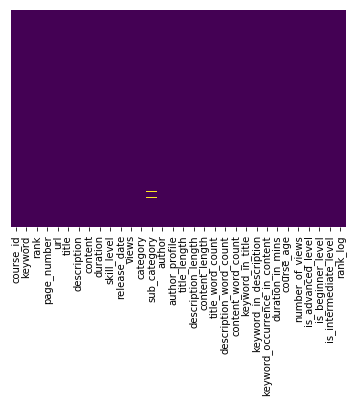

In [63]:
# check the null value
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [65]:
"""
1. Select a list of features as predictor input
2. Assign a variable to be target as output
"""

predictors = [
    'title_length',
    'description_length',
    'content_length',
    'title_word_count',
    'description_word_count',
    'content_word_count',
    'keyword_in_title',
    'keyword_in_description',
    'keyword_occurrence_in_content',
    'duration_in_mins',
    'course_age',
    'number_of_views',
    'is_advanced_level',
    'is_beginner_level',
    'is_intermediate_level'
]

target = 'rank_log'

### Build Model - GLM

In [66]:
"""

1. Pass the model parameters to the model settings
2. Build a Linear Regression Model instance
3. Train and test the data
"""

setting = ModelSetting.create() \
.add(ModelSetting.TRAINING_SIZE, 0.8) \
.add(ModelSetting.SEED, 77) \
.add(ModelSetting.MODEL_NAME, Model.LINEAR_REGRESSION) \
.add(ModelSetting.ALPAH, 0.5) \
.add(ModelSetting.PREDICTORS, predictors) \
.add(ModelSetting.TARGET, target) \
.setup()

In [67]:
model = LinearRegressorModel(data, setting)

In [68]:
# Train the model
model.train()

In [69]:
model.model_performance()

{'alpha': 0.5,
 'model_name': 'Linear Regression',
 'predictors': 'title_length,description_length,content_length,title_word_count,description_word_count,content_word_count,keyword_in_title,keyword_in_description,keyword_occurrence_in_content,duration_in_mins,course_age,number_of_views,is_advanced_level,is_beginner_level,is_intermediate_level',
 'seed': 77,
 'target': 'rank_log',
 'train_mse': 0.03372512060994532,
 'train_r2': 0.798264718588463,
 'train_rmse': 0.18364400510211412,
 'training_size': 0.8}

In [70]:
model.evaluate()

In [71]:
model.test_report.show()

Mean Squared Error: 0.03437653090616072
Root Mean Squared Error: 0.18540909067831793
R2 Score: 0.846718448384329


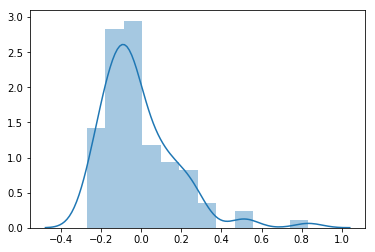

In [72]:
# check the distribution of difference between actual data and predicted data without transforming to orignal rank
sns.distplot(model.predict(model.X_test)-model.y_test)
plt.show()

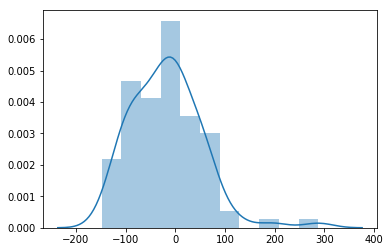

In [73]:
# check the distribution of difference between actual data and predicted data with transforming to orignal rank
sns.distplot(model.predict(model.X_test).apply(lambda x: np.power(10,x))-model.y_test.apply(lambda x: np.power(10,x)))
plt.show()

### Prediction

In [19]:
'''
Prediction for a random course
'''
course = data.sample(1)
course

,course_id,keyword,rank,page_number,url,title,description,content,duration,skill_level,...,keyword_in_title,keyword_in_description,keyword_occurrence_in_content,duration_in_mins,course_age,number_of_views,is_advanced_level,is_beginner_level,is_intermediate_level,rank_log
154,648913,python,156,4,https://www.lynda.com/Business-Skills-tutorial...,Technology for Product Managers,Learn the key technology terms and trends that...,Product managers must know technology basics. ...,46m 44s,Beginner,...,0,0,0,46,209,22799,0,1,0,2.193125


In [20]:
print('Actual Rank={}'.format(course['rank'].values[0]))
print('Predicted Rank={:.2f}'.format(model.predict(course).apply(lambda x: np.power(10,x)).values[0]))

Actual Rank=156
Predicted Rank=155.47


In [58]:
'''
Prediction for a random course
'''
course2 = model.test_data.sample(1)
course2

,title_length,description_length,content_length,title_word_count,description_word_count,content_word_count,keyword_in_title,keyword_in_description,keyword_occurrence_in_content,duration_in_mins,course_age,number_of_views,is_advanced_level,is_beginner_level,is_intermediate_level,rank_log
389,34,139,1244,4,23,182,0,0,0,145,1244,374880,0,0,1,2.594393


In [59]:
print('Actual Rank={}'.format(course2['rank_log'].apply(lambda x: np.power(10,x)).values[0]))
print('Predicted Rank={:.2f}'.format(model.predict(course2).apply(lambda x: np.power(10,x)).values[0]))

Actual Rank=392.9999999999999
Predicted Rank=348.27


### Tensorflow Linear Model

In [21]:
import tensorflow as tf

In [22]:
print('Tensorflow version={}'.format(tf.__version__))

Tensorflow version=1.10.0


In [23]:
tf.reset_default_graph()

In [24]:
"""
Set up the hyper parameters
"""

learning_rate = 0.01
epochs = 10000
batch_size = 200
display_step = 1000

n_features = len(predictors)
n_classes = 1

X = data[predictors].as_matrix().astype('float')
y = data[['rank_log']].as_matrix()

split_ratio = 0.8
seed = 77
np.random.seed(seed)
train_size = int(len(X) * split_ratio)

# shuffled_ix = np.random.permutation(len(X))
# X_shuffled = X[shuffled_ix]
# y_shuflled = y[shuffled_ix]

#X_train, X_test = X_shuffled[0:train_size], X_shuffled[train_size:]
#y_train, y_test = y_shuflled[0:train_size], y_shuflled[train_size:]

In [25]:
# Make sure same training and testing dataset
X_train, X_test = model.X_train.as_matrix().astype('float'), model.X_test.as_matrix().astype('float')
y_train, y_test = model.y_train.as_matrix().reshape(-1,1).astype('float'), model.y_test.as_matrix().reshape(-1,1).astype('float')

In [26]:
# Normilize the data to avoid Vanishing gradient
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
"""
Build compuation graph
"""
tf.set_random_seed(seed)

W = tf.Variable(tf.random_normal([n_features, n_classes]), name='Weights')
b = tf.Variable(tf.zeros([n_classes]), name='Biases')

tf_X = tf.placeholder(tf.float32, shape=[None, n_features])
tf_y = tf.placeholder(tf.float32, shape=[None, n_classes])

output = tf.add(tf.matmul(tf_X, W), b)

In [28]:
"""
Create cost function
"""

# L2
l2_cost = tf.reduce_mean(tf.square(tf.subtract(output, tf_y)))
l2_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(l2_cost)

#Ridge loss function
alpha = tf.constant([0.5])
ridge_regularization = tf.multiply(alpha, tf.reduce_sum(tf.square(W)))
ridge_cost = tf.add(l2_cost, ridge_regularization)
ridge_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ridge_cost)

In [29]:
# SSE is the sum of squared error
sse = tf.reduce_sum(tf.square(tf.subtract(output, tf_y)))
# SST is the sum of squared total
sst = tf.reduce_sum(tf.square(tf.subtract(tf_y, tf.reduce_mean(tf_y))))

mse = tf.reduce_mean(tf.square(tf.subtract(output, tf_y)))
rmse = tf.sqrt(mse)
r2 = tf.subtract(tf.constant(1.), tf.truediv(sse, sst))

In [30]:
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

In [31]:
loss = []
train_error = []
test_error = []
test_r2 = []

for i in range(epochs):
    # for batch training
#     rand_ix = np.random.choice(train_size, size=batch_size, replace=False)
#     X_train_rand = X_train[rand_ix]
#     y_train_rand = y_train[rand_ix]
    
    _, _, _cost = session.run([l2_optimizer, output, l2_cost], feed_dict={tf_X: X_train, tf_y: y_train})
##    _, _, _cost = session.run([ridge_optimizer, output, ridge_cost], feed_dict={tf_X: X_train_rand, tf_y: y_train_rand})
    loss.append(_cost)
    
    _train_error = session.run(rmse, feed_dict={tf_X: X_train, tf_y: y_train})
    _test_error = session.run(rmse, feed_dict={tf_X:X_test, tf_y: y_test})
    train_error.append(_train_error)
    test_error.append(_test_error)
    _test_r2 = session.run(r2, feed_dict={tf_X:X_test, tf_y: y_test})
    test_r2.append(_test_r2)

    if i % display_step==0:
        print('Epoch:{}/{} - Cost:{:.4f} - Train Error:{:.4f} - Test Error:{:.4f} - Test R2:{}\n'.format(i, epochs, _cost, _train_error, _test_error, _test_r2))

Epoch:0/10000 - Cost:10.3806 - Train Error:3.1741 - Test Error:3.1833 - Test R2:-44.18388366699219

Epoch:1000/10000 - Cost:0.0589 - Train Error:0.2425 - Test Error:0.2550 - Test R2:0.7099595069885254

Epoch:2000/10000 - Cost:0.0413 - Train Error:0.2031 - Test Error:0.2090 - Test R2:0.8053005933761597

Epoch:3000/10000 - Cost:0.0357 - Train Error:0.1889 - Test Error:0.1905 - Test R2:0.8381944894790649

Epoch:4000/10000 - Cost:0.0344 - Train Error:0.1856 - Test Error:0.1869 - Test R2:0.8442934155464172

Epoch:5000/10000 - Cost:0.0339 - Train Error:0.1842 - Test Error:0.1857 - Test R2:0.8462910652160645

Epoch:6000/10000 - Cost:0.0338 - Train Error:0.1837 - Test Error:0.1854 - Test R2:0.846724808216095

Epoch:7000/10000 - Cost:0.0337 - Train Error:0.1837 - Test Error:0.1854 - Test R2:0.846668004989624

Epoch:8000/10000 - Cost:0.0337 - Train Error:0.1836 - Test Error:0.1854 - Test R2:0.8466806411743164

Epoch:9000/10000 - Cost:0.0337 - Train Error:0.1836 - Test Error:0.1854 - Test R2:0.84

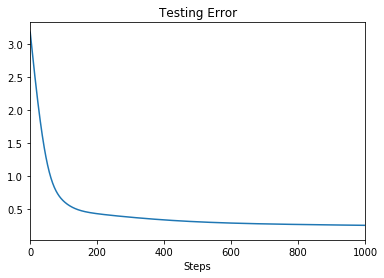

In [32]:
plt.title('Testing Error')
plt.xlim(0,1000)
plt.xlabel('Steps')
plt.plot(test_error)
plt.show()

In [33]:
# predict one input
x_input = scaler.transform(course[predictors].as_matrix())
pred = session.run(output, feed_dict={tf_X: x_input})
final_pred = np.power(10, pred)[0][0]

In [34]:
print('Actual Rank={}'.format(course['rank'].values[0]))
print('Predicted Rank={:.2f}'.format(final_pred))

Actual Rank=156
Predicted Rank=155.46


In [35]:
test_prediction = session.run(output, feed_dict={tf_X: X_test})

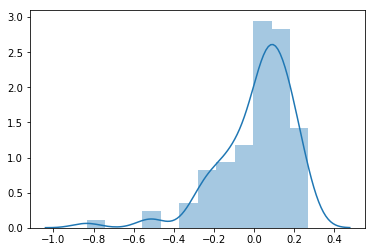

In [36]:
sns.distplot((y_test-test_prediction))
plt.show()